In [31]:
from dotenv import load_dotenv
from mistralai.client import MistralClient
from mistralai.models.chat_completion import ChatMessage
import os
import json
from dotenv import load_dotenv
import pandas as pd
# Set your Mistral AI API key
load_dotenv('.env')

# Define the model
client = MistralClient()

def genai_forecast(
        data, 
        horizon,
        model, 
        time_idx='Period', 
        forecast_col = 'Forecast',
        verbose=False
        ):
    
    prompt = f"""
    You are tasked with forecasting a time series. Your goal is to analyze the given data and provide a forecast for future values. Follow these steps carefully:

    1. First, examine the time series data provided:

    <time_series_data>
    {data.to_string()}
    </time_series_data>

    2. Analyze the data for key characteristics such as trend, seasonality, and any apparent patterns or anomalies. Consider factors like:
    - Overall trend (increasing, decreasing, or stable)
    - Presence of seasonal patterns
    - Any obvious outliers or structural breaks

    3. Based on your analysis, choose an appropriate forecasting method. Some common methods include:
    - Simple moving average
    - Exponential smoothing
    - ARIMA (Autoregressive Integrated Moving Average)
    - Prophet (for data with strong seasonal effects and several seasons of historical data)

    4. Apply the chosen forecasting method to predict future values. The forecast horizon is:

    <forecast_horizon>
    {horizon}
    </forecast_horizon>

    5. Provide your forecast in the following format:
    <forecast>
    [List your predicted values here, one per line]
    </forecast>

    6. Explain your reasoning and methodology in detail. Include:
    <explanation>
    - Why you chose the particular forecasting method
    - Any assumptions you made
    - How you handled any challenges in the data (e.g., outliers, missing values)
    - Your confidence in the forecast and why
    </explanation>

    7. Finally, mention any limitations or potential issues with your forecast. Consider factors like:
    - The quality and quantity of the input data
    - Any external factors not captured in the historical data that might affect future values
    - The inherent uncertainty in forecasting

    Remember to use your best judgment and statistical knowledge throughout this process. If you're unsure about any aspect, state your uncertainties clearly in your explanation.

    Return the answer in JSON format, containing two keys: '{time_idx}' 
    and '{forecast_col}', and list of values assigned to them. 
    Return only the forecasts, not the Python code.

    """
    
    if verbose:
        print(prompt)

    messages = [ChatMessage(role="user", content=prompt)]
    response = client.chat(
        model=model,
        messages=messages,
        temperature=0, 
        response_format={"type": "json_object"},
    )
    
    output = response.choices[0].message.content
    
    try:
        json_object = json.loads(output)
        df = pd.DataFrame(json_object)
        df[time_idx] = df[time_idx].astype(data.index.dtype)
    except:
        df = output
        print(output)
    
    return df

In [27]:
import numpy as np
from typing import Tuple, List

def get_champagne(
        years: Tuple[int, int] = (2018, 2023),
        normal_days: dict =  {'n': 1000, 'p': 0.02},
        weekdays: dict = {4: {'n': 1800, 'p': 0.03},5: {'n': 2000, 'p': 0.05}},
        special_events: dict = {
            (29, 12): {'n': 1500, 'p': 0.1},
            (30, 12): {'n': 2000, 'p': 0.2},
            (31, 12): {'n': 2000, 'p': 0.7}
            },
            trend=.01,
            seas_months=[6, 7, 8],
            seas_coef=1.2):

    """Model for sparkling wine demand"""
    
    df = pd.DataFrame({
        'date': pd.date_range(f'{years[0]}-01-01', f'{years[1]}-12-31')    
    })
    
    df['weekday'] =  df['date'].dt.weekday
    df['monthday'] =  df['date'].dt.day
    df['month'] =  df['date'].dt.month
    df['week'] =  df['date'].dt.strftime('%U')
    df['year'] =  df['date'].dt.year
    
    normal_days_amount = np.random.binomial(**normal_days, size=len(df))
    df['amount'] = normal_days_amount
    
    # Trend
    df['amount'] += np.array(df.index.values) * trend
    df['amount'] = df['amount'].astype(int)
    
    if weekdays:
        for wd, params in weekdays.items():
            mask = df.weekday == wd
            df.loc[mask, 'amount'] = np.random.binomial(**params, size=mask.sum())
    
    if special_events:
        for d, params in special_events.items():
            mask = (df.monthday == d[0]) & (df.month == d[1]) 
            df.loc[mask, 'amount'] = np.random.binomial(**params, size=mask.sum())
            col_name = f'special_event_{d[0]}_{d[1]}'
            df[col_name] = 0
            df.loc[mask, col_name] = 1
    
    # Aggregation
    df = df[['year', 'month', 'amount']]
    df = df.groupby(['year', 'month']).sum()
    
    # Create period date
    period = df\
        .reset_index() \
        .apply(lambda x: pd.Period(f"{x['year']}-{x['month']}", freq='M'), axis=1)
    
    df['period'] = period.tolist()
    df = df.reset_index()
    
    # Adding seasonality
    df.loc[df.month.isin(seas_months), 'amount'] *= seas_coef
    df['amount'] = df['amount'].astype(int)
    
    return df[['period', 'amount']]

/var/folders/3b/nsk7_52x0xzgmc814y8vtbhr0000gq/T/ipykernel_5172/444717304.py:60: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[1248.  1425.6 1435.2 1429.2 1454.4 1437.6 1543.2 1575.6 1581.6 1713.6
 1644.  1640.4 1789.2 1794.  1832.4 1743.6 1862.4 1946.4 1849.2 2036.4
 1929.6 1993.2 2168.4 2040.  2028.  2244.  2085.6]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.loc[df.month.isin(seas_months), 'amount'] *= seas_coef


<Axes: xlabel='period'>

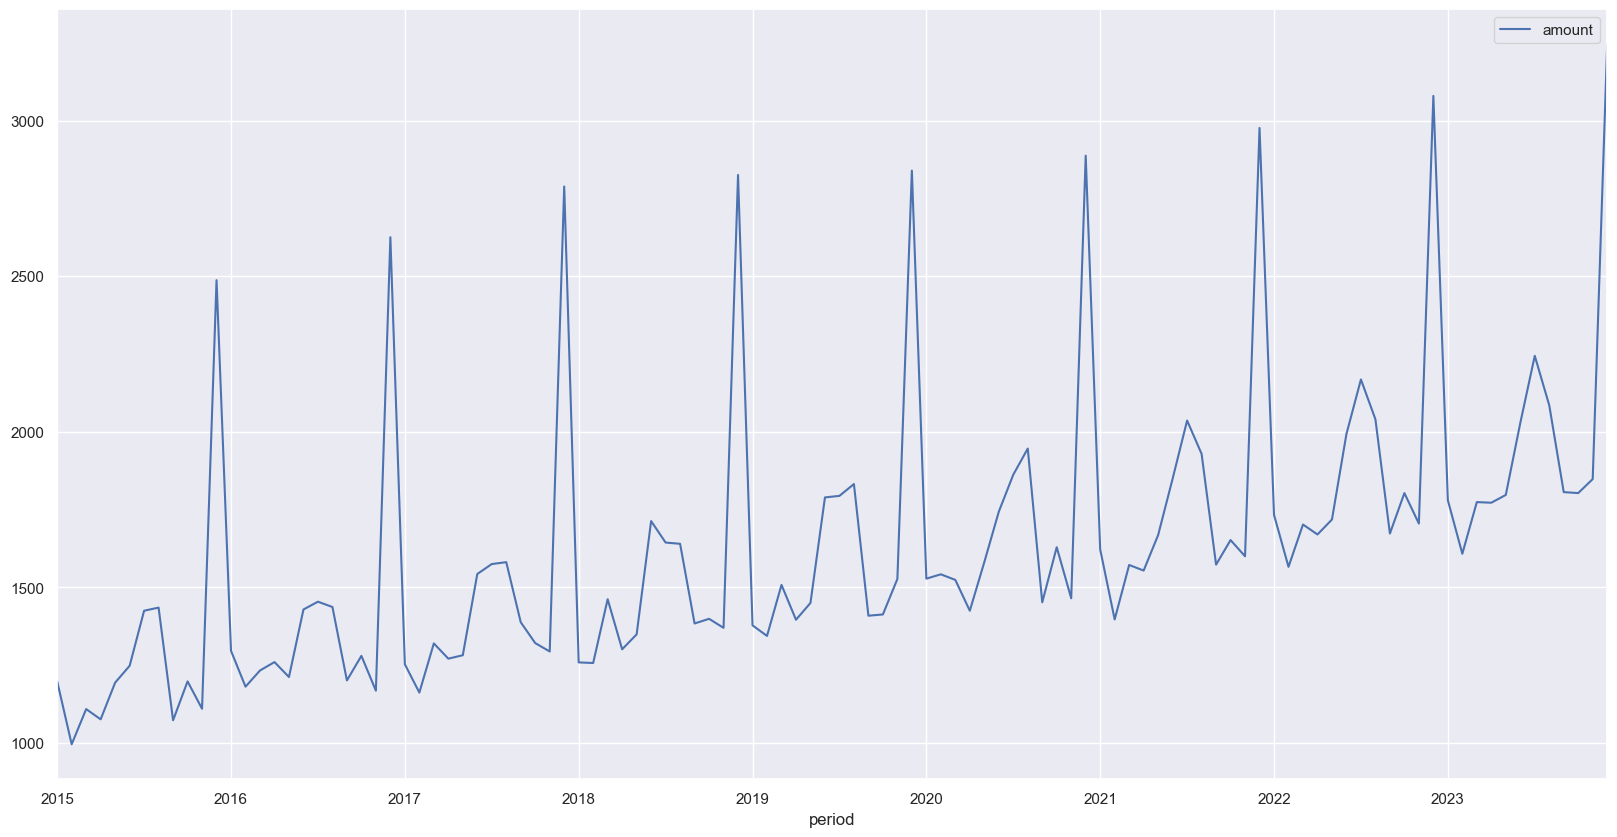

In [50]:
START_YEAR = 2015
END_YEAR = 2023
SPLIT_DATE = '2022-12-31'

np.random.seed(7)

data = get_champagne(years=(START_YEAR, END_YEAR),
                    special_events={(31, 12): {'n': 2000, 'p': 0.7}})
data.plot(x='period', y='amount')

In [53]:
data.to_csv('test-data.csv')

In [54]:
import numpy as np
import pandas as pd

def get_champagne_test(
    years=(2018, 2023),
    normal_days={'n': 1000, 'p': 0.02},
    weekdays={4: {'n': 1800, 'p': 0.03}, 5: {'n': 2000, 'p': 0.05}},
    special_events={(29, 12): {'n': 1500, 'p': 0.1}, (30, 12): {'n': 2000, 'p': 0.2}, (31, 12): {'n': 2000, 'p': 0.7}},
    trend=0.01,
    seas_months=[6, 7, 8],
    seas_coef=1.2
):
    df = pd.DataFrame({'date': pd.date_range(f'{years[0]}-01-01', f'{years[1]}-12-31')})
    df['weekday'] = df['date'].dt.weekday
    df['monthday'] = df['date'].dt.day
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year

    df['amount'] = np.random.binomial(**normal_days, size=len(df))
    df['amount'] += np.arange(len(df)) * trend
    
    for wd, params in weekdays.items():
        mask = df['weekday'] == wd
        df.loc[mask, 'amount'] = np.random.binomial(**params, size=mask.sum())
    
    for (day, month), params in special_events.items():
        mask = (df['monthday'] == day) & (df['month'] == month)
        df.loc[mask, 'amount'] = np.random.binomial(**params, size=mask.sum())
        df[f'special_event_{day}_{month}'] = mask.astype(int)

    df = df.groupby(['year', 'month'])['amount'].sum().reset_index()
    df['period'] = pd.PeriodIndex(year=df['year'], month=df['month'], freq='M')
    df.loc[df['month'].isin(seas_months), 'amount'] *= seas_coef
    
    return df[['period', 'amount']].astype({'amount': int})

/var/folders/3b/nsk7_52x0xzgmc814y8vtbhr0000gq/T/ipykernel_5172/1897621171.py:32: FutureWarning: Constructing PeriodIndex from fields is deprecated. Use PeriodIndex.from_fields instead.
  df['period'] = pd.PeriodIndex(year=df['year'], month=df['month'], freq='M')


<Axes: xlabel='period'>

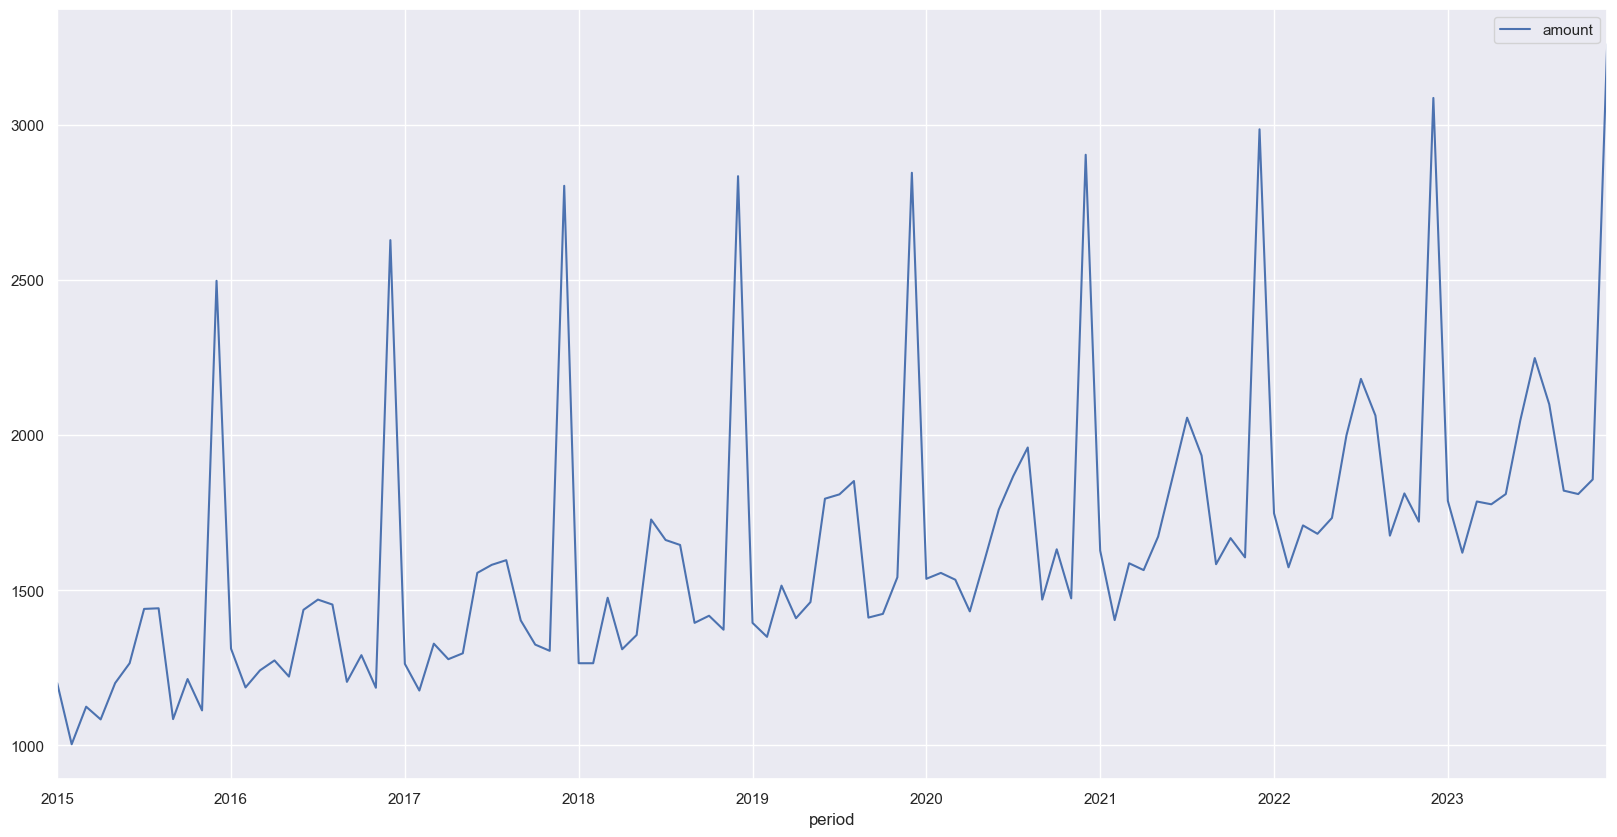

In [56]:
START_YEAR = 2015
END_YEAR = 2023
SPLIT_DATE = '2022-12-31'

np.random.seed(7)

data_test = get_champagne_test(years=(START_YEAR, END_YEAR),
                    special_events={(31, 12): {'n': 2000, 'p': 0.7}})
data_test.plot(x='period', y='amount')

In [57]:
data.to_csv('test-data-1.csv')

<Axes: xlabel='period'>

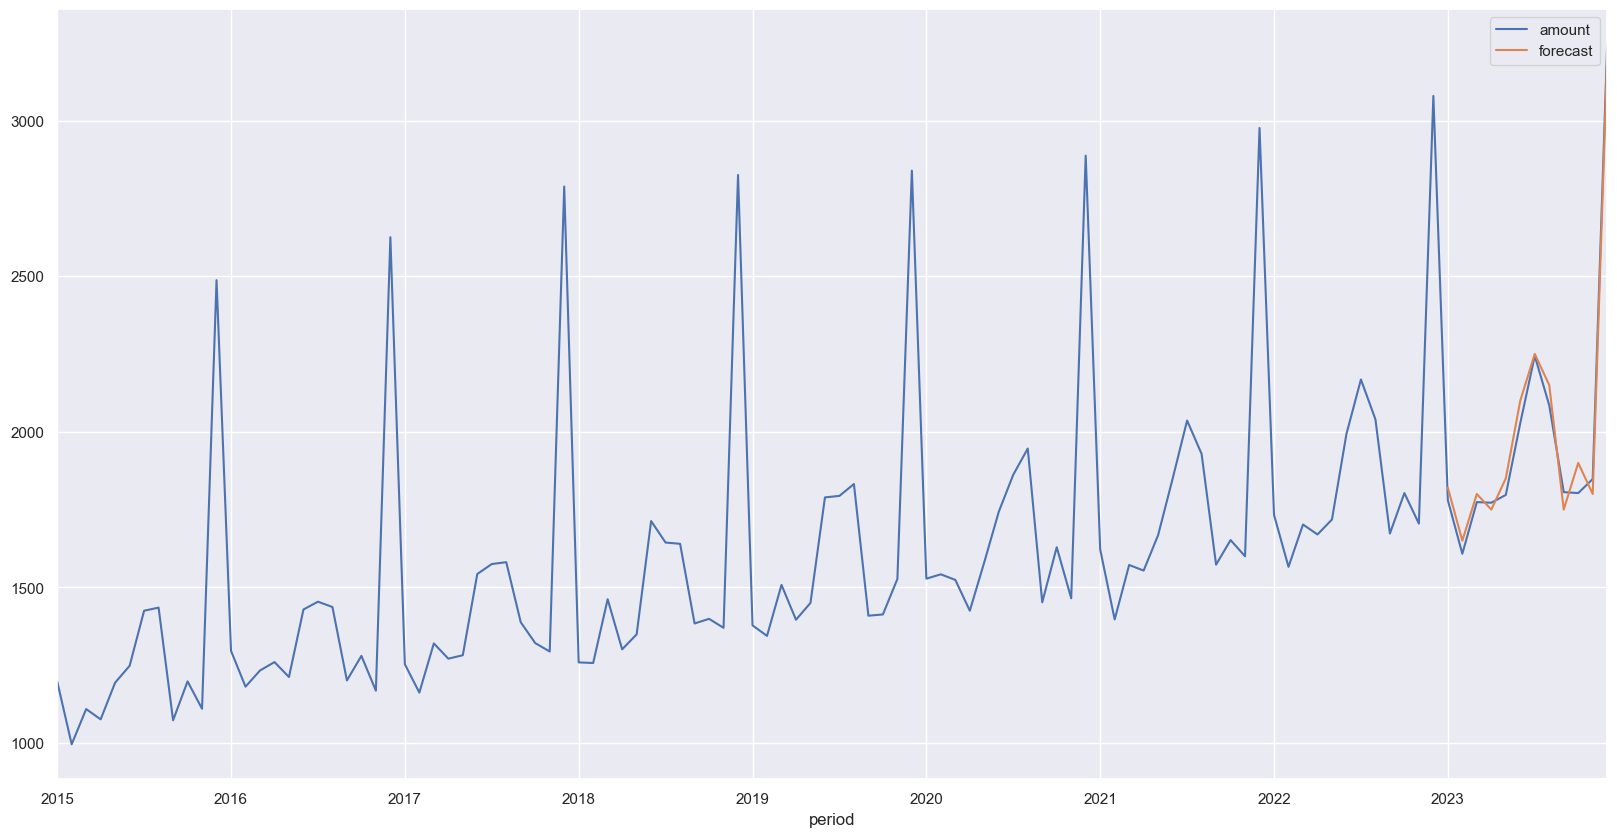

In [39]:
train_data = data.head(-12)
test_data = data.tail(12)

# Forecasting
champagne_forecast = genai_forecast(
        data = train_data.set_index('period'), 
        horizon = 12,
        model = "mistral-large-2407",
        time_idx = 'period',
        forecast_col = 'forecast'
)

# Plotting 
data.merge(champagne_forecast, on='period', how='outer').plot(x='period', y=['amount', 'forecast'])

In [46]:
train_data = data.head(-12)
test_data = data.tail(12)
# Forecasting
champagne_forecast_merged = genai_forecast(
        data = train_data.set_index('period'), 
        horizon = 12,
        model = "mistral-large-2407",
        time_idx = 'period',
        forecast_col = 'forecast'
)

merged_data = data.merge(champagne_forecast_merged, on='period', how='outer')

In [48]:
merged_data

,period,amount,forecast
0,2015-01,1198,NaN
1,2015-02,996,NaN
2,2015-03,1109,NaN
3,2015-04,1076,NaN
4,2015-05,1194,NaN
...,...,...,...
103,2023-08,2085,2150.0
104,2023-09,1806,1750.0
105,2023-10,1803,1900.0
106,2023-11,1848,1800.0


<Axes: xlabel='period'>

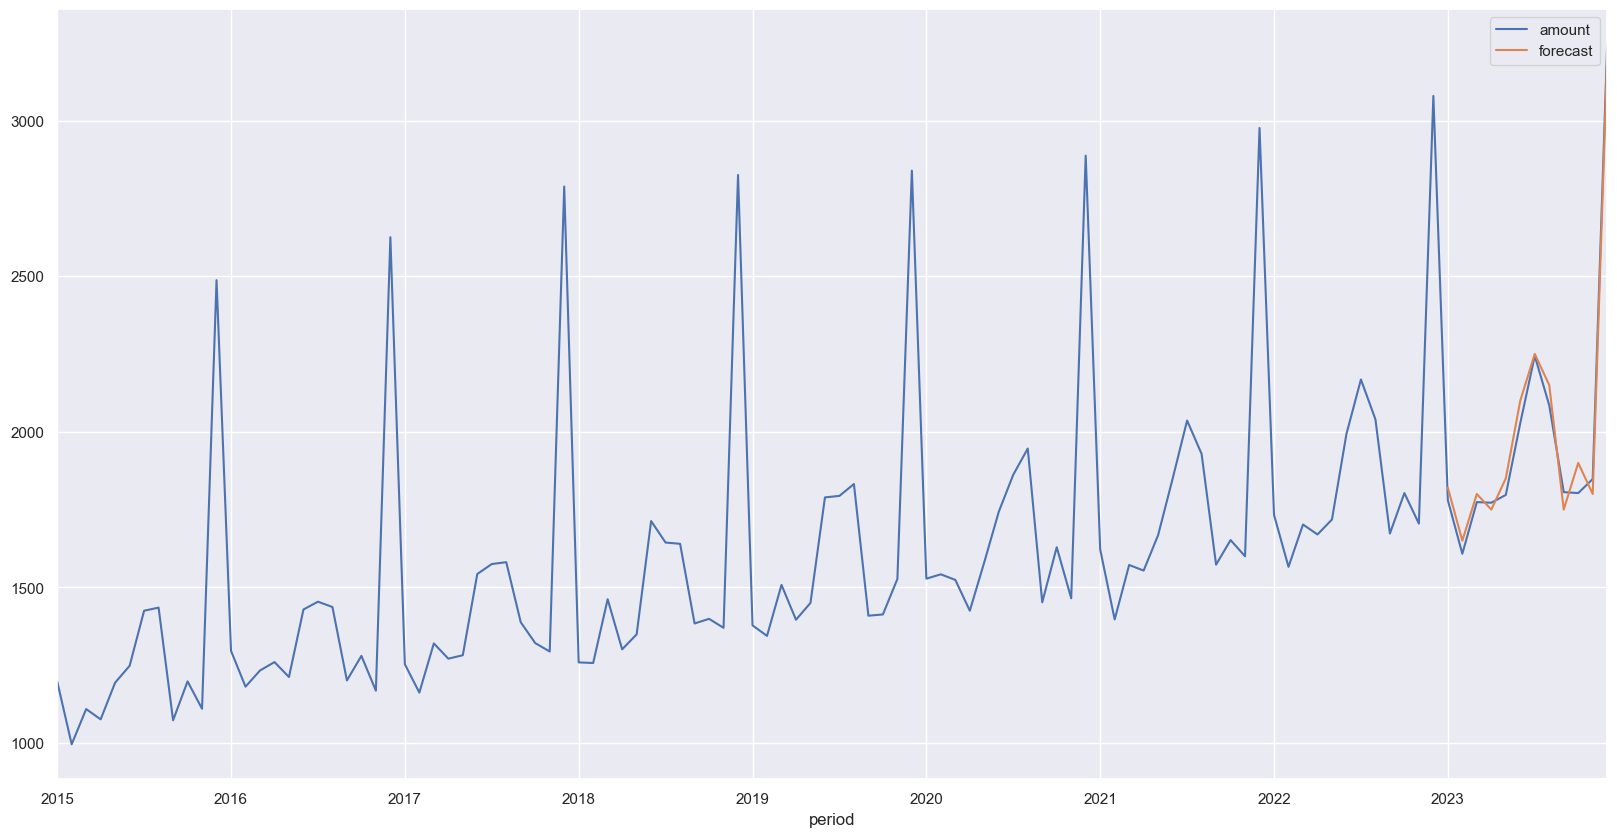

In [49]:
merged_data.plot(x='period', y=['amount', 'forecast'])

In [35]:
train_data

,period,amount
0,2015-01,1198
1,2015-02,996
2,2015-03,1109
3,2015-04,1076
4,2015-05,1194
...,...,...
91,2022-08,2040
92,2022-09,1673
93,2022-10,1803
94,2022-11,1705


<Axes: xlabel='period'>

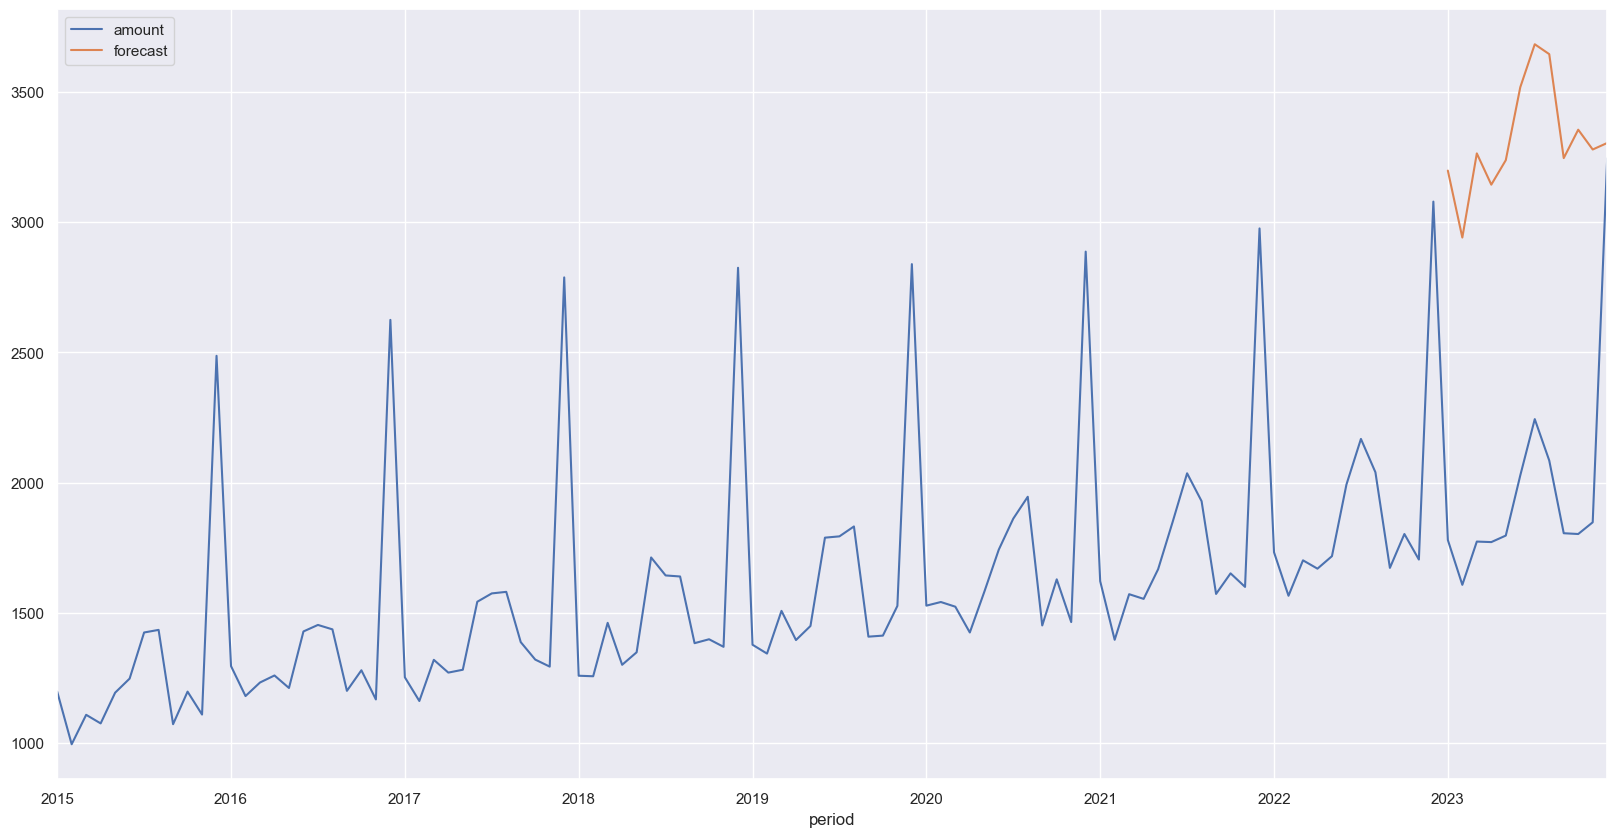

In [34]:
train_data = data.head(-12)
test_data = data.tail(12)

# Forecasting
champagne_chatgpt = genai_forecast(
        data = train_data.set_index('period'), 
        horizon = 12,
        model = "mistral-small-latest",
        time_idx = 'period',
        forecast_col = 'forecast'
)

# Plotting 
data.merge(champagne_chatgpt, on='period', how='outer').plot(x='period', y=['amount', 'forecast'])